In [1]:
from dataset import *
from video import SimulationVideo
from video import NuscenesVideo, NuscenesVideoDebug, PFVideo
from MapMatching import MapMatching

In [2]:
import copy
class Simulation():
    def __init__(self, model, **kwargs):
        pass
    
    def run(self, N):
        pass
    
class DynamicSimulation():
    def __init__(self, model, **kwargs):
        self.model = model
        self.dataset = DynamicSimulatedDataset()
        self.video = SimulationVideo()
    
    def run(self, N):
        for t in range(0,N):
            print(f"frame {t}")
            zw, covw, prior, video_data = self.dataset.getData(t)
            print("prior", prior)
            points, polynoms = self.model.run(zw,covw,prior)
            self.video.save(t, prior, video_data, points, polynoms, self.model.getDebugInfo())
            
class NuscenesSimulation():
    def __init__(self, model, scene=5, **kwargs):
        self.model = model
        directory = kwargs.pop('directory', r"C:\Users\gadli\old_pc\Tau\Thesis\nuScenes\v1.0-mini")
        self.dataset = NuscenesDataset(directory=directory,scene=scene)
        #self.video = NuscenesVideo(history=True, scene=scene)
        #self.video_debug = NuscenesVideoDebug(history=True, scene=scene)
        self.pf_video = PFVideo(history=True, scene=scene)
        self.map_matching = MapMatching(N=500)
        self.lane = None
        self.scene = scene
        
    def getBestLane(self, prior):
        if self.lane is None:
                self.lane = prior[0]
                lane = prior[0]
        else:
            for pr in prior:
                if 1:#if np.linalg.norm(self.lane["poly"][1]-pr["poly"][1]) < 2 and np.linalg.norm(self.lane["poly"][0]-pr["poly"][0]) < 0.1:
                    lane = pr
                    self.lane = pr

        lanes = [lane]
        return lanes
    
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
        
    def run(self,start, N, generate_video=False, video_with_priors=False, debug=False, translate=True):
        start_idx = start
        first = True
        for t in range(start_idx,start_idx + N):
            print(f"frame {t}")
            zw, covw, prior, video_data, nusc_map = self.dataset.getData(t)
            if first:
                translation = np.array(video_data["pos"][0:2])
                print("translation", translation)
                first = False
                
            #lanes = self.getBestLane(prior)
            lanes = copy.deepcopy(prior)
            if translate:
                lanes = self.translatePrior(translation, lanes)
                zw = self.translateMeasurements(zw, translation)
            prior_list = []
            for lane in lanes:
                (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
                prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
    
            points, polynoms = self.model.run(zw,covw,prior_list)
            if translate:
                points, polynoms = self.translateOutput(points, polynoms, -1*translation)
                
            #Run map-matching!
            extended_tracks = self.model.getExtendedTracks()
            orig_world_ref = video_data["pos"]
            world_ref = np.array([orig_world_ref[0]-translation[0], orig_world_ref[1]-translation[1]]) 
            self.map_matching.run(extended_tracks, nusc_map, orig_world_ref, world_ref, video_data["rot"], video_data["heading"], video_data["odometry"])
            
            try:
                self.video.save(t,video_data, polynoms, nusc_map, video_with_priors=video_with_priors)
            except:
                pass
            try:
                self.video_debug.save(t,video_data, polynoms,points, nusc_map,self.model.getDebugInfo(), video_with_priors=video_with_priors)
            except:
                pass
            #try:
            mm_results = self.map_matching.getResults()
            mm_results["pf_best_pos"] += translation[0:2]
            mm_results["pf_mean_pos"] += translation[0:2]
            print(mm_results)
            self.pf_video.save(t,video_data, mm_results, polynoms, nusc_map)
            #except:
                #pass
        
        if generate_video:
            try:
                self.video.generate(name=f"video\scene{self.scene}.avi", fps=5)
            except:
                pass
            try:
                self.video_debug.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass
            try:
                self.pf_video.generate(name=f"video\scene{self.scene}_debug.avi", fps=5)
            except:
                pass

scene_id={} scene_name={} map_name={} 0 scene-0103 boston-seaport


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\dataset.py:238: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


frame 0
translation [ 600.74994389 1647.14030292]
Number of point tracks before run() 0
Number of extended tracks before run() 0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 600.69937171, 1647.18055882]), 'pf_best_theta': -0.5039916585708302, 'pf_mean_pos': array([ 600.74730954, 1647.14310591]), 'pf_mean_theta': -0.503991658570834}
frame 1
Number of point tracks before run() 51
Number of extended tracks before run() 0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


{'pf_best_pos': array([ 601.50062758, 1646.71884245]), 'pf_best_theta': -0.5058139081404951, 'pf_mean_pos': array([ 601.31714712, 1646.81474222]), 'pf_mean_theta': -0.5058139140138933}
frame 2
Number of point tracks before run() 67
Number of extended tracks before run() 0
{'pf_best_pos': array([ 601.82597462, 1646.53064048]), 'pf_best_theta': -0.5075821210772808, 'pf_mean_pos': array([ 601.82820027, 1646.5191157 ]), 'pf_mean_theta': -0.5075821087387155}
frame 3
Number of point tracks before run() 80
Number of extended tracks before run() 0
{'pf_best_pos': array([ 602.57450257, 1646.09369174]), 'pf_best_theta': -0.5105843348553769, 'pf_mean_pos': array([ 602.36547166, 1646.20548672]), 'pf_mean_theta': -0.5105843148433942}
frame 4
Number of point tracks before run() 86
Number of extended tracks before run() 0
{'pf_best_pos': array([ 603.1728867 , 1645.74719035]), 'pf_best_theta': -0.5142598231918494, 'pf_mean_pos': array([ 602.88077349, 1645.90709512]), 'pf_mean_theta': -0.51425978839905

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 608.76850675, 1642.3514245 ]), 'pf_best_theta': -0.557281128433111, 'pf_mean_pos': array([ 608.6528934 , 1642.37252006]), 'pf_mean_theta': -0.5572810328003528}
frame 14
Number of point tracks before run() 95
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 608.70951719, 1642.34807879]), 'pf_best_theta': -0.5609495617015345, 'pf_mean_pos': array([ 609.12579345, 1642.07337522]), 'pf_mean_theta': -0.5609496557581349}
frame 15
Number of point tracks before run() 95
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 610.83386305, 1640.99865725]), 'pf_best_theta': -0.5655558614020597, 'pf_mean_pos': array([ 609.64775574, 1641.73886932]), 'pf_mean_theta': -0.5655559127676287}
frame 16
Number of point tracks before run() 94
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 609.40062366, 1641.87864021]), 'pf_best_theta': -0.5696499031296787, 'pf_mean_pos': array([ 610.13343396, 1641.42498031]), 'pf_mean_theta': -0.5696498446341794}
frame 17
Number of point tracks before run() 98
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 612.29543887, 1640.06206453]), 'pf_best_theta': -0.579796980297921, 'pf_mean_pos': array([ 611.10579575, 1640.77761477]), 'pf_mean_theta': -0.5797969306355386}
frame 18
Number of point tracks before run() 102
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 611.49070569, 1640.435573  ]), 'pf_best_theta': -0.5842662128632341, 'pf_mean_pos': array([ 611.55437819, 1640.47443878]), 'pf_mean_theta': -0.5842662728932254}
frame 19
Number of point tracks before run() 98
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 610.00653795, 1641.45030669]), 'pf_best_theta': -0.5880824864623531, 'pf_mean_pos': array([ 612.07666148, 1640.12710225]), 'pf_mean_theta': -0.5880825249088474}
frame 20
Number of point tracks before run() 100
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 612.14342953, 1640.07620171]), 'pf_best_theta': -0.5915011852357246, 'pf_mean_pos': array([ 612.58693681, 1639.78332517]), 'pf_mean_theta': -0.5915011041642636}
frame 21
Number of point tracks before run() 106
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 612.64029918, 1639.71848783]), 'pf_best_theta': -0.594972211173384, 'pf_mean_pos': array([ 613.06975229, 1639.45334743]), 'pf_mean_theta': -0.5949721021146179}
frame 22
Number of point tracks before run() 100
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 611.85223849, 1640.23191347]), 'pf_best_theta': -0.5985310143786968, 'pf_mean_pos': array([ 613.55511079, 1639.12673453]), 'pf_mean_theta': -0.5985309506539281}
frame 23
Number of point tracks before run() 100
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 613.94092173, 1638.76618384]), 'pf_best_theta': -0.6080641350326284, 'pf_mean_pos': array([ 614.45397389, 1638.48689618]), 'pf_mean_theta': -0.6080640625899075}
frame 24
Number of point tracks before run() 104
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 615.07620942, 1638.01089456]), 'pf_best_theta': -0.6119798739970084, 'pf_mean_pos': array([ 615.07691742, 1638.01261505]), 'pf_mean_theta': -0.6119798762063781}
frame 25
Number of point tracks before run() 97
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 614.90349321, 1638.10615335]), 'pf_best_theta': -0.6152381341830515, 'pf_mean_pos': array([ 615.59867643, 1637.64041147]), 'pf_mean_theta': -0.6152381176690237}
frame 26
Number of point tracks before run() 94
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 616.10317109, 1637.27674046]), 'pf_best_theta': -0.6189342288784703, 'pf_mean_pos': array([ 616.19703909, 1637.20975839]), 'pf_mean_theta': -0.6189342012015645}
frame 27
Number of point tracks before run() 94
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 616.83626627, 1636.7476268 ]), 'pf_best_theta': -0.6229773404781569, 'pf_mean_pos': array([ 616.72061275, 1636.83043593]), 'pf_mean_theta': -0.6229772974686145}
frame 28
Number of point tracks before run() 96
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 617.19401407, 1636.48985672]), 'pf_best_theta': -0.6241375594670542, 'pf_mean_pos': array([ 617.21661599, 1636.47294479]), 'pf_mean_theta': -0.6241374956819599}
frame 29
Number of point tracks before run() 95
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 618.2961004 , 1635.66643018]), 'pf_best_theta': -0.6332538932379101, 'pf_mean_pos': array([ 618.22597057, 1635.72011057]), 'pf_mean_theta': -0.6332538325277621}
frame 30
Number of point tracks before run() 101
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 618.70529703, 1635.35935276]), 'pf_best_theta': -0.636883385860747, 'pf_mean_pos': array([ 618.744643  , 1635.33090487]), 'pf_mean_theta': -0.6368833214223073}
frame 31
Number of point tracks before run() 88
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 619.17619673, 1635.00423659]), 'pf_best_theta': -0.640188945584327, 'pf_mean_pos': array([ 619.25655813, 1634.94491916]), 'pf_mean_theta': -0.6401888907705457}
frame 32
Number of point tracks before run() 98
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 619.80344996, 1634.52628269]), 'pf_best_theta': -0.6445554141578484, 'pf_mean_pos': array([ 619.77599422, 1634.54450908]), 'pf_mean_theta': -0.6445553176336898}
frame 33
Number of point tracks before run() 98
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 620.11018691, 1634.28516267]), 'pf_best_theta': -0.6498795097235068, 'pf_mean_pos': array([ 620.24916813, 1634.17784187]), 'pf_mean_theta': -0.6498794301882661}
frame 34
Number of point tracks before run() 95
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 620.51730365, 1633.9578216 ]), 'pf_best_theta': -0.6548025436878939, 'pf_mean_pos': array([ 620.77618167, 1633.7640677 ]), 'pf_mean_theta': -0.6548025359617875}
frame 35
Number of point tracks before run() 95
Number of extended tracks before run() 3
Updating extended object track =  0
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 621.89011717, 1632.87951983]), 'pf_best_theta': -0.6621201836883412, 'pf_mean_pos': array([ 621.7802017 , 1632.96870512]), 'pf_mean_theta': -0.6621200787009818}
frame 36
Number of point tracks before run() 102
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 621.70332947, 1633.01666994]), 'pf_best_theta': -0.6639264106134934, 'pf_mean_pos': array([ 622.30593828, 1632.54988091]), 'pf_mean_theta': -0.663926344434873}
frame 37
Number of point tracks before run() 105
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 622.93127679, 1632.08021579]), 'pf_best_theta': -0.6678144449106309, 'pf_mean_pos': array([ 622.81353266, 1632.13522751]), 'pf_mean_theta': -0.667814413706259}
frame 38
Number of point tracks before run() 101
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 623.18081129, 1631.85104683]), 'pf_best_theta': -0.6699070009110071, 'pf_mean_pos': array([ 623.25866396, 1631.78382701]), 'pf_mean_theta': -0.6699069267905775}
frame 39
Number of point tracks before run() 97
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 625.0266999 , 1630.37487241]), 'pf_best_theta': -0.6738731449096553, 'pf_mean_pos': array([ 623.74443353, 1631.38348342]), 'pf_mean_theta': -0.673873162484957}
frame 40
Number of point tracks before run() 98
Number of extended tracks before run() 3
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 625.46752761, 1629.98063392]), 'pf_best_theta': -0.6760398512836474, 'pf_mean_pos': array([ 624.21116677, 1630.99739065]), 'pf_mean_theta': -0.6760398364464764}
frame 41
Number of point tracks before run() 94
Number of extended tracks before run() 3
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 625.35362465, 1630.04581744]), 'pf_best_theta': -0.6804212952583772, 'pf_mean_pos': array([ 625.13633697, 1630.20122755]), 'pf_mean_theta': -0.6804213632630158}
frame 42
Number of point tracks before run() 92
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 625.9696237, 1629.5262971]), 'pf_best_theta': -0.6822401125899802, 'pf_mean_pos': array([ 625.73783374, 1629.70263311]), 'pf_mean_theta': -0.6822399936875642}
frame 43
Number of point tracks before run() 86
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 625.3220364 , 1629.99674173]), 'pf_best_theta': -0.6839279719856171, 'pf_mean_pos': array([ 626.21418864, 1629.30371913]), 'pf_mean_theta': -0.6839279619080272}
frame 44
Number of point tracks before run() 91
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 626.76109132, 1628.86263741]), 'pf_best_theta': -0.6858254095309362, 'pf_mean_pos': array([ 626.71104885, 1628.87824197]), 'pf_mean_theta': -0.6858255081879063}
frame 45
Number of point tracks before run() 94
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 626.08071055, 1629.4017336 ]), 'pf_best_theta': -0.6872865343734329, 'pf_mean_pos': array([ 627.16353249, 1628.49345284]), 'pf_mean_theta': -0.6872866505662155}
frame 46
Number of point tracks before run() 96
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 627.51291605, 1628.20655399]), 'pf_best_theta': -0.6902631868994082, 'pf_mean_pos': array([ 627.7066287 , 1628.02045913]), 'pf_mean_theta': -0.6902631441135074}
frame 47
Number of point tracks before run() 96
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 628.34130747, 1627.50028991]), 'pf_best_theta': -0.6926844721770209, 'pf_mean_pos': array([ 628.67895647, 1627.18694989]), 'pf_mean_theta': -0.6926845632091571}
frame 48
Number of point tracks before run() 100
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 629.13591609, 1626.81131362]), 'pf_best_theta': -0.6939832053715542, 'pf_mean_pos': array([ 629.19309284, 1626.7416603 ]), 'pf_mean_theta': -0.6939832679553705}
frame 49
Number of point tracks before run() 99
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 628.6787418 , 1627.17047388]), 'pf_best_theta': -0.6944761504203161, 'pf_mean_pos': array([ 629.72730042, 1626.28891848]), 'pf_mean_theta': -0.6944762564039473}
frame 50
Number of point tracks before run() 98
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 630.08370681, 1626.00587579]), 'pf_best_theta': -0.6956057746274227, 'pf_mean_pos': array([ 630.05678671, 1625.99940167]), 'pf_mean_theta': -0.6956058607843708}
frame 51
Number of point tracks before run() 91
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 630.61023385, 1625.54814863]), 'pf_best_theta': -0.6957042579987291, 'pf_mean_pos': array([ 630.39407436, 1625.70348439]), 'pf_mean_theta': -0.6957043482865128}
frame 52
Number of point tracks before run() 87
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 630.70969281, 1625.33512221]), 'pf_best_theta': -0.6959323590808606, 'pf_mean_pos': array([ 631.02977476, 1625.11726108]), 'pf_mean_theta': -0.6959323203272489}
frame 53
Number of point tracks before run() 95
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 631.47035754, 1624.67429286]), 'pf_best_theta': -0.6957205168516953, 'pf_mean_pos': array([ 631.49729929, 1624.70400806]), 'pf_mean_theta': -0.6957204721637006}
frame 54
Number of point tracks before run() 98
Number of extended tracks before run() 0
{'pf_best_pos': array([ 631.95057614, 1624.26565468]), 'pf_best_theta': -0.6943451596649015, 'pf_mean_pos': array([ 631.99381289, 1624.28150382]), 'pf_mean_theta': -0.69434511182262}
frame 55
Number of point tracks before run() 103
Number of extended tracks before run() 0
{'pf_best_pos': array([ 632.31882956, 1623.94486702]), 'pf_best_theta': -0.6935905915436926, 'pf_mean_pos': array([ 632.4601772 , 1623.87525125]), 'pf_mean_theta': -0.6935905442401163}
frame 56
Number of point tracks before run() 101
Number of extended tracks before run() 0
{'pf_best_pos': array([ 633.00855015, 1623.33399317]), 'pf_best_theta': -0.693603225394356, 'pf_mean_pos': array([ 632.94175989, 1623.44872165]), 'pf_mean_theta': -0.693603179095

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 640.18979203, 1617.23416203]), 'pf_best_theta': -0.6928590214980277, 'pf_mean_pos': array([ 640.21559471, 1617.20601575]), 'pf_mean_theta': -0.6928589849378975}
frame 68
Number of point tracks before run() 116
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 638.0162863 , 1619.00468729]), 'pf_best_theta': -0.6924368306169804, 'pf_mean_pos': array([ 640.55325942, 1616.91918473]), 'pf_mean_theta': -0.6924368824104519}
frame 69
Number of point tracks before run() 105
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 638.40163217, 1618.6744258 ]), 'pf_best_theta': -0.6926825275854531, 'pf_mean_pos': array([ 640.915682  , 1616.60856968]), 'pf_mean_theta': -0.6926826030565787}
frame 70
Number of point tracks before run() 107
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 638.88993238, 1618.25810678]), 'pf_best_theta': -0.6926635149086335, 'pf_mean_pos': array([ 641.56126352, 1616.05815437]), 'pf_mean_theta': -0.6926635906783002}
frame 71
Number of point tracks before run() 108
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 641.88265946, 1615.78133562]), 'pf_best_theta': -0.6934398348593334, 'pf_mean_pos': array([ 641.93224919, 1615.73580249]), 'pf_mean_theta': -0.6934397507391309}
frame 72
Number of point tracks before run() 110
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 642.17542496, 1615.53240121]), 'pf_best_theta': -0.6935535627017746, 'pf_mean_pos': array([ 642.21185894, 1615.48836599]), 'pf_mean_theta': -0.6935534630656319}
frame 73
Number of point tracks before run() 110
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 642.65237516, 1615.1174631 ]), 'pf_best_theta': -0.6936403852046604, 'pf_mean_pos': array([ 642.48451831, 1615.25262216]), 'pf_mean_theta': -0.6936402472740825}
frame 74
Number of point tracks before run() 103
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 643.24561155, 1614.59853336]), 'pf_best_theta': -0.6944552703862019, 'pf_mean_pos': array([ 642.99601115, 1614.80544123]), 'pf_mean_theta': -0.6944551312805392}
frame 75
Number of point tracks before run() 102
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 643.32367317, 1614.52189886]), 'pf_best_theta': -0.6941527312923457, 'pf_mean_pos': array([ 643.25015578, 1614.58750182]), 'pf_mean_theta': -0.6941526469332179}
frame 76
Number of point tracks before run() 97
Number of extended tracks before run() 1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 643.29344738, 1614.55730083]), 'pf_best_theta': -0.6939829908899657, 'pf_mean_pos': array([ 643.46198822, 1614.40813228]), 'pf_mean_theta': -0.6939829091355689}
frame 77
Number of point tracks before run() 92
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 643.6612275 , 1614.22271889]), 'pf_best_theta': -0.6939210232147843, 'pf_mean_pos': array([ 643.69845459, 1614.20453196]), 'pf_mean_theta': -0.693921007234564}
frame 78
Number of point tracks before run() 98
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 643.96296479, 1613.9634628 ]), 'pf_best_theta': -0.6943126548084386, 'pf_mean_pos': array([ 643.91141986, 1614.0215498 ]), 'pf_mean_theta': -0.694312645639591}
frame 79
Number of point tracks before run() 105
Number of extended tracks before run() 2
Updating extended object track = 

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


 1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 644.14199562, 1613.81034869]), 'pf_best_theta': -0.6939921131940117, 'pf_mean_pos': array([ 644.14771829, 1613.82401087]), 'pf_mean_theta': -0.6939920129629803}
frame 80
Number of point tracks before run() 107
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 644.63198011, 1613.39010744]), 'pf_best_theta': -0.6937990521421051, 'pf_mean_pos': array([ 644.52563944, 1613.49826622]), 'pf_mean_theta': -0.6937989773511892}
frame 81
Number of point tracks before run() 108
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 644.57064734, 1613.45091343]), 'pf_best_theta': -0.6939109130247867, 'pf_mean_pos': array([ 644.70649794, 1613.3448649 ]), 'pf_mean_theta': -0.6939108824844895}
frame 82
Number of point tracks before run() 103
Number of extended tracks before run() 2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 644.96712599, 1613.10571694]), 'pf_best_theta': -0.6941495459966074, 'pf_mean_pos': array([ 644.87409497, 1613.19927012]), 'pf_mean_theta': -0.6941494648586256}
frame 83
Number of point tracks before run() 106
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 644.53881423, 1613.49487939]), 'pf_best_theta': -0.6939681505477542, 'pf_mean_pos': array([ 644.99338995, 1613.09460466]), 'pf_mean_theta': -0.6939681831828729}
frame 84
Number of point tracks before run() 100
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 645.27082597, 1612.83496491]), 'pf_best_theta': -0.6934350112124044, 'pf_mean_pos': array([ 645.15463387, 1612.95364905]), 'pf_mean_theta': -0.6934349419142487}
frame 85
Number of point tracks before run() 98
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 645.46836985, 1612.66941582]), 'pf_best_theta': -0.6935793647605051, 'pf_mean_pos': array([ 645.34212507, 1612.78981796]), 'pf_mean_theta': -0.6935793021085735}
frame 86
Number of point tracks before run() 87
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 645.52635357, 1612.63138   ]), 'pf_best_theta': -0.693620047159313, 'pf_mean_pos': array([ 645.59407899, 1612.56897122]), 'pf_mean_theta': -0.6936199788196691}
frame 87
Number of point tracks before run() 103
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 645.84273435, 1612.34370977]), 'pf_best_theta': -0.6934154103247332, 'pf_mean_pos': array([ 645.68918274, 1612.4876414 ]), 'pf_mean_theta': -0.6934154245350352}
frame 88
Number of point tracks before run() 94
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 646.09830374, 1612.12650278]), 'pf_best_theta': -0.6933176702786206, 'pf_mean_pos': array([ 645.78385648, 1612.40309206]), 'pf_mean_theta': -0.6933175945760885}
frame 89
Number of point tracks before run() 98
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 646.03827265, 1612.17403028]), 'pf_best_theta': -0.6931022763733301, 'pf_mean_pos': array([ 645.90783239, 1612.29759266]), 'pf_mean_theta': -0.6931023065024565}
frame 90
Number of point tracks before run() 94
Number of extended tracks before run() 4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 646.33753012, 1611.91241394]), 'pf_best_theta': -0.6934360112786786, 'pf_mean_pos': array([ 645.99382987, 1612.22241209]), 'pf_mean_theta': -0.6934360369132909}
frame 91
Number of point tracks before run() 87
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 646.17092808, 1612.05991685]), 'pf_best_theta': -0.6932561601832465, 'pf_mean_pos': array([ 646.08003585, 1612.1460887 ]), 'pf_mean_theta': -0.6932561944617774}
frame 92
Number of point tracks before run() 76
Number of extended tracks before run() 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 646.3909666 , 1611.86713728]), 'pf_best_theta': -0.6931884089860088, 'pf_mean_pos': array([ 646.26784172, 1611.9815487 ]), 'pf_mean_theta': -0.6931884426295307}
frame 93
Number of point tracks before run() 78
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 646.52067124, 1611.75336732]), 'pf_best_theta': -0.6934130301620609, 'pf_mean_pos': array([ 646.36933992, 1611.89251992]), 'pf_mean_theta': -0.693413076637517}
frame 94
Number of point tracks before run() 80
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 647.33459488, 1611.04968418]), 'pf_best_theta': -0.6936983465143292, 'pf_mean_pos': array([ 646.45239962, 1611.81841421]), 'pf_mean_theta': -0.6936983451824752}
frame 95
Number of point tracks before run() 68
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
{'pf_best_pos': array([ 647.45768122, 1610.93701482]), 'pf_best_theta': -0.6940756498470737, 'pf_mean_pos': array([ 646.55877563, 1611.72093291]), 'pf_mean_theta': -0.694075649142029}
frame 96
Number of point tracks before run() 71
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 646.6572844 , 1611.63627859]), 'pf_best_theta': -0.693670514924646, 'pf_mean_pos': array([ 646.68803586, 1611.60957494]), 'pf_mean_theta': -0.6936704054029769}
frame 97
Number of point tracks before run() 80
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 647.99690748, 1610.47200923]), 'pf_best_theta': -0.6943033376148322, 'pf_mean_pos': array([ 646.97264922, 1611.3603977 ]), 'pf_mean_theta': -0.6943033886609584}
frame 98
Number of point tracks before run() 77
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 647.83399485, 1610.61533947]), 'pf_best_theta': -0.6947667393321986, 'pf_mean_pos': array([ 647.11328999, 1611.23812461]), 'pf_mean_theta': -0.6947668011777597}
frame 99
Number of point tracks before run() 78
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.10465415, 1610.37486729]), 'pf_best_theta': -0.6950280756751894, 'pf_mean_pos': array([ 647.23930866, 1611.12699136]), 'pf_mean_theta': -0.6950281397391052}
frame 100
Number of point tracks before run() 82
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 648.11957781, 1610.36152557]), 'pf_best_theta': -0.6953702011520924, 'pf_mean_pos': array([ 647.7868361 , 1610.64725864]), 'pf_mean_theta': -0.6953702424671893}
frame 101
Number of point tracks before run() 85
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 647.37640777, 1611.00011415]), 'pf_best_theta': -0.6955748001067552, 'pf_mean_pos': array([ 647.80145129, 1610.63333613]), 'pf_mean_theta': -0.6955746393161096}
frame 102
Number of point tracks before run() 74
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 647.56525752, 1610.83203206]), 'pf_best_theta': -0.6955857105971011, 'pf_mean_pos': array([ 647.87768461, 1610.56412942]), 'pf_mean_theta': -0.6955855546605311}
frame 103
Number of point tracks before run() 74
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 648.76186988, 1609.78918045]), 'pf_best_theta': -0.6959337364868574, 'pf_mean_pos': array([ 648.11539352, 1610.35567488]), 'pf_mean_theta': -0.6959337005122088}
frame 104
Number of point tracks before run() 87
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.87285539, 1609.6910353 ]), 'pf_best_theta': -0.6962612554155809, 'pf_mean_pos': array([ 648.27514594, 1610.21561482]), 'pf_mean_theta': -0.6962612011884493}
frame 105
Number of point tracks before run() 95
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.60306209, 1609.93160665]), 'pf_best_theta': -0.6965203372171018, 'pf_mean_pos': array([ 648.46110535, 1610.05147709]), 'pf_mean_theta': -0.6965204048363269}
frame 106
Number of point tracks before run() 91
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.78654993, 1609.76797052]), 'pf_best_theta': -0.6970346796927132, 'pf_mean_pos': array([ 648.606666  , 1609.92283062]), 'pf_mean_theta': -0.697034767929969}
frame 107
Number of point tracks before run() 89
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 649.02747797, 1609.55616322]), 'pf_best_theta': -0.6974517095736852, 'pf_mean_pos': array([ 648.74400425, 1609.8017309 ]), 'pf_mean_theta': -0.6974517831204449}
frame 108
Number of point tracks before run() 88
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 647.86502467, 1610.56222389]), 'pf_best_theta': -0.6977792400622969, 'pf_mean_pos': array([ 648.72571877, 1609.81709369]), 'pf_mean_theta': -0.6977791624977813}
frame 109
Number of point tracks before run() 80
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 647.95728122, 1610.48031368]), 'pf_best_theta': -0.6976653986354266, 'pf_mean_pos': array([ 648.96244791, 1609.60721354]), 'pf_mean_theta': -0.6976653052879498}
frame 110
Number of point tracks before run() 92
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.17899303, 1610.28471435]), 'pf_best_theta': -0.6973561074597363, 'pf_mean_pos': array([ 649.10845933, 1609.47831843]), 'pf_mean_theta': -0.6973560237285906}
frame 111
Number of point tracks before run() 90
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.53285711, 1609.97041664]), 'pf_best_theta': -0.6970628761921023, 'pf_mean_pos': array([ 649.2438901 , 1609.35979616]), 'pf_mean_theta': -0.6970627862443678}
frame 112
Number of point tracks before run() 96
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.74412997, 1609.79092914]), 'pf_best_theta': -0.6966791135047483, 'pf_mean_pos': array([ 649.41623522, 1609.20826017]), 'pf_mean_theta': -0.6966790249294256}
frame 113
Number of point tracks before run() 94
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.85716164, 1609.68583959]), 'pf_best_theta': -0.6961885482472296, 'pf_mean_pos': array([ 649.43406025, 1609.19089917]), 'pf_mean_theta': -0.6961884705860524}
frame 114
Number of point tracks before run() 90
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 648.86318275, 1609.68048597]), 'pf_best_theta': -0.695888572889471, 'pf_mean_pos': array([ 649.56827117, 1609.0708965 ]), 'pf_mean_theta': -0.6958884857585333}
frame 115
Number of point tracks before run() 84
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 649.09712854, 1609.47825953]), 'pf_best_theta': -0.6949541428893236, 'pf_mean_pos': array([ 649.77967165, 1608.88827923]), 'pf_mean_theta': -0.6949540486320365}
frame 116
Number of point tracks before run() 87
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 649.35596855, 1609.25536477]), 'pf_best_theta': -0.6947361699397385, 'pf_mean_pos': array([ 650.02444411, 1608.67640127]), 'pf_mean_theta': -0.6947360569157233}
frame 117
Number of point tracks before run() 86
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 649.43571708, 1609.18560462]), 'pf_best_theta': -0.6945932108522088, 'pf_mean_pos': array([ 650.09519523, 1608.61447442]), 'pf_mean_theta': -0.6945931096859563}
frame 118
Number of point tracks before run() 90
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 649.44863194, 1609.17463515]), 'pf_best_theta': -0.6944999489496348, 'pf_mean_pos': array([ 650.30381074, 1608.4338981 ]), 'pf_mean_theta': -0.694499845040562}
frame 119
Number of point tracks before run() 95
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 649.42003805, 1609.19922206]), 'pf_best_theta': -0.6943614061591838, 'pf_mean_pos': array([ 650.45308936, 1608.30565611]), 'pf_mean_theta': -0.6943613037270655}
frame 120
Number of point tracks before run() 92
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 649.7927585 , 1608.87906947]), 'pf_best_theta': -0.6944982342469026, 'pf_mean_pos': array([ 650.61432617, 1608.16715657]), 'pf_mean_theta': -0.6944981345102826}
frame 121
Number of point tracks before run() 92
Number of extended tracks before run() 5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 650.24058805, 1608.48903783]), 'pf_best_theta': -0.6940278829870499, 'pf_mean_pos': array([ 650.88926243, 1607.93206411]), 'pf_mean_theta': -0.6940278949132278}
frame 122
Number of point tracks before run() 92
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 650.19149861, 1608.53149844]), 'pf_best_theta': -0.6939257088115296, 'pf_mean_pos': array([ 651.02271408, 1607.81663321]), 'pf_mean_theta': -0.6939257170968868}
frame 123
Number of point tracks before run() 96
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 650.43060917, 1608.32665513]), 'pf_best_theta': -0.6939480935651821, 'pf_mean_pos': array([ 651.17814834, 1607.68347444]), 'pf_mean_theta': -0.6939481118562403}
frame 124
Number of point tracks before run() 108
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 650.47784157, 1608.28560523]), 'pf_best_theta': -0.6940194223681901, 'pf_mean_pos': array([ 651.33057864, 1607.55099655]), 'pf_mean_theta': -0.6940194524784853}
frame 125
Number of point tracks before run() 110
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 652.09474433, 1606.89383888]), 'pf_best_theta': -0.6939148349328974, 'pf_mean_pos': array([ 651.49413265, 1607.4087998 ]), 'pf_mean_theta': -0.6939147489483041}
frame 126
Number of point tracks before run() 99
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 652.80750094, 1606.26591706]), 'pf_best_theta': -0.6940984122552578, 'pf_mean_pos': array([ 651.68991299, 1607.24044139]), 'pf_mean_theta': -0.6940983727931863}
frame 127
Number of point tracks before run() 109
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 653.55078923, 1605.63667794]), 'pf_best_theta': -0.6940694352113637, 'pf_mean_pos': array([ 652.08884853, 1606.89616512]), 'pf_mean_theta': -0.6940694789534797}
frame 128
Number of point tracks before run() 109
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 653.68149038, 1605.52456547]), 'pf_best_theta': -0.6939730874974854, 'pf_mean_pos': array([ 652.30044384, 1606.71445324]), 'pf_mean_theta': -0.6939731045613958}
frame 129
Number of point tracks before run() 111
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 651.75909794, 1607.18314739]), 'pf_best_theta': -0.6937685550832731, 'pf_mean_pos': array([ 652.49877686, 1606.54255149]), 'pf_mean_theta': -0.6937686512994531}
frame 130
Number of point tracks before run() 104
Number of extended tracks before run() 6
Updating extended object track = 

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])


 3
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 653.04641404, 1606.06652911]), 'pf_best_theta': -0.6934450394855038, 'pf_mean_pos': array([ 652.71608503, 1606.35525666]), 'pf_mean_theta': -0.6934449249269918}
frame 131
Number of point tracks before run() 109
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 654.98432294, 1604.39749617]), 'pf_best_theta': -0.6934418843917904, 'pf_mean_pos': array([ 652.94616645, 1606.15488245]), 'pf_mean_theta': -0.6934419204161761}
frame 132
Number of point tracks before run() 104
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 654.75442277, 1604.5960692 ]), 'pf_best_theta': -0.6935725868181244, 'pf_mean_pos': array([ 653.17873991, 1605.9542686 ]), 'pf_mean_theta': -0.6935726045436249}
frame 133
Number of point tracks before run() 105
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 651.77226509, 1607.18660799]), 'pf_best_theta': -0.6934402139907485, 'pf_mean_pos': array([ 653.58250995, 1605.60621449]), 'pf_mean_theta': -0.6934401586942699}
frame 134
Number of point tracks before run() 98
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 655.06679249, 1604.31401916]), 'pf_best_theta': -0.6936470786051574, 'pf_mean_pos': array([ 653.84019941, 1605.3806091 ]), 'pf_mean_theta': -0.6936471405778939}
frame 135
Number of point tracks before run() 102
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 651.83828158, 1607.12816925]), 'pf_best_theta': -0.6935848480108726, 'pf_mean_pos': array([ 653.98697733, 1605.25342254]), 'pf_mean_theta': -0.6935847838128599}
frame 136
Number of point tracks before run() 104
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  5


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 652.06110709, 1606.92218415]), 'pf_best_theta': -0.6932552128164078, 'pf_mean_pos': array([ 654.24596625, 1605.02885365]), 'pf_mean_theta': -0.6932552668751399}
frame 137
Number of point tracks before run() 102
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  5


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 652.59584559, 1606.44783111]), 'pf_best_theta': -0.6933333797901549, 'pf_mean_pos': array([ 654.48562316, 1604.81650837]), 'pf_mean_theta': -0.6933333412534392}
frame 138
Number of point tracks before run() 101
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  1
Updating extended object track =  5


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 653.00316421, 1606.08881937]), 'pf_best_theta': -0.6936515872669924, 'pf_mean_pos': array([ 654.62393281, 1604.69227132]), 'pf_mean_theta': -0.693651495977921}
frame 139
Number of point tracks before run() 102
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 655.71343775, 1603.74515952]), 'pf_best_theta': -0.6934677609400737, 'pf_mean_pos': array([ 655.04289205, 1604.33121495]), 'pf_mean_theta': -0.6934676417780519}
frame 140
Number of point tracks before run() 99
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 656.55814913, 1603.01801406]), 'pf_best_theta': -0.693408595819025, 'pf_mean_pos': array([ 655.2095172 , 1604.18944754]), 'pf_mean_theta': -0.6934084775620561}
frame 141
Number of point tracks before run() 102
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 657.88761255, 1601.87987505]), 'pf_best_theta': -0.6935860887188552, 'pf_mean_pos': array([ 655.44004162, 1603.98953314]), 'pf_mean_theta': -0.6935860897314616}
frame 142
Number of point tracks before run() 103
Number of extended tracks before run() 7
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 657.01978815, 1602.61825949]), 'pf_best_theta': -0.6937296058514151, 'pf_mean_pos': array([ 655.84792336, 1603.63679971]), 'pf_mean_theta': -0.693729560310616}
frame 143
Number of point tracks before run() 106
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 657.52988985, 1602.17546511]), 'pf_best_theta': -0.694339528023808, 'pf_mean_pos': array([ 656.19326036, 1603.33364321]), 'pf_mean_theta': -0.6943395076588164}
frame 144
Number of point tracks before run() 112
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 656.85882541, 1602.75103276]), 'pf_best_theta': -0.6946665846105446, 'pf_mean_pos': array([ 656.60689749, 1602.97156954]), 'pf_mean_theta': -0.6946664768271369}
frame 145
Number of point tracks before run() 112
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 656.50513817, 1603.06628365]), 'pf_best_theta': -0.6956562210177171, 'pf_mean_pos': array([ 657.06926583, 1602.5713873 ]), 'pf_mean_theta': -0.69565610289156}
frame 146
Number of point tracks before run() 111
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 658.92054944, 1600.94880975]), 'pf_best_theta': -0.6956495529680584, 'pf_mean_pos': array([ 657.30202528, 1602.37216321]), 'pf_mean_theta': -0.6956495064329249}
frame 147
Number of point tracks before run() 97
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 658.27104016, 1601.52600921]), 'pf_best_theta': -0.6955822201315991, 'pf_mean_pos': array([ 657.53733886, 1602.17011961]), 'pf_mean_theta': -0.6955820948358905}
frame 148
Number of point tracks before run() 107
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  7


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 657.68761273, 1602.03547627]), 'pf_best_theta': -0.6958813612495014, 'pf_mean_pos': array([ 657.80583804, 1601.93530191]), 'pf_mean_theta': -0.6958812342538335}
frame 149
Number of point tracks before run() 98
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 657.10474154, 1602.52959381]), 'pf_best_theta': -0.6962405874101201, 'pf_mean_pos': array([ 658.04997763, 1601.72058121]), 'pf_mean_theta': -0.6962407221398191}
frame 150
Number of point tracks before run() 96
Number of extended tracks before run() 10


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  9


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 658.11173969, 1601.67267353]), 'pf_best_theta': -0.698087980701112, 'pf_mean_pos': array([ 658.93164937, 1600.94696425]), 'pf_mean_theta': -0.6980880109578977}
frame 151
Number of point tracks before run() 96
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 659.72740375, 1600.24056908]), 'pf_best_theta': -0.6982239519870435, 'pf_mean_pos': array([ 659.1412653 , 1600.76483989]), 'pf_mean_theta': -0.6982237919271055}
frame 152
Number of point tracks before run() 103
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  8
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 661.29509765, 1598.90793521]), 'pf_best_theta': -0.6984819490564913, 'pf_mean_pos': array([ 659.47566798, 1600.47737116]), 'pf_mean_theta': -0.6984820145763517}
frame 153
Number of point tracks before run() 100
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 661.87678885, 1598.41121029]), 'pf_best_theta': -0.6993033979728009, 'pf_mean_pos': array([ 659.74866759, 1600.23842685]), 'pf_mean_theta': -0.6993033553161939}
frame 154
Number of point tracks before run() 106
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 658.1191134 , 1601.66872979]), 'pf_best_theta': -0.6999859561238511, 'pf_mean_pos': array([ 660.15143173, 1599.8871035 ]), 'pf_mean_theta': -0.6999860066989289}
frame 155
Number of point tracks before run() 112
Number of extended tracks before run() 9
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 660.49622899, 1599.60313053]), 'pf_best_theta': -0.700938588228297, 'pf_mean_pos': array([ 660.95645763, 1599.19312925]), 'pf_mean_theta': -0.7009385064487679}
frame 156
Number of point tracks before run() 115
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 660.67856153, 1599.44673394]), 'pf_best_theta': -0.7015377562157328, 'pf_mean_pos': array([ 661.269502  , 1598.92445007]), 'pf_mean_theta': -0.7015377000521685}
frame 157
Number of point tracks before run() 113
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 660.89062947, 1599.26300319]), 'pf_best_theta': -0.7024348564787863, 'pf_mean_pos': array([ 661.58659278, 1598.64688285]), 'pf_mean_theta': -0.7024347939683155}
frame 158
Number of point tracks before run() 110
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 661.50268269, 1598.72648452]), 'pf_best_theta': -0.703438339351151, 'pf_mean_pos': array([ 661.96791151, 1598.3131766 ]), 'pf_mean_theta': -0.703438255161056}
frame 159
Number of point tracks before run() 126
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 660.83138954, 1599.30092456]), 'pf_best_theta': -0.7037753731381233, 'pf_mean_pos': array([ 662.30307541, 1598.02050885]), 'pf_mean_theta': -0.703775396446787}
frame 160
Number of point tracks before run() 125
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 661.3379251 , 1598.85941944]), 'pf_best_theta': -0.7048648283530472, 'pf_mean_pos': array([ 662.8675751 , 1597.52772305]), 'pf_mean_theta': -0.7048648560956071}
frame 161
Number of point tracks before run() 110
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 662.09248865, 1598.19078749]), 'pf_best_theta': -0.7056910859559276, 'pf_mean_pos': array([ 663.20938958, 1597.22614027]), 'pf_mean_theta': -0.705690978904614}
frame 162
Number of point tracks before run() 114
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  5


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 662.41979378, 1597.90378106]), 'pf_best_theta': -0.7061981963092485, 'pf_mean_pos': array([ 663.56300467, 1596.91619229]), 'pf_mean_theta': -0.7061980836687147}
frame 163
Number of point tracks before run() 113
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 662.35386901, 1597.96725256]), 'pf_best_theta': -0.7071156652525081, 'pf_mean_pos': array([ 663.90501255, 1596.60792712]), 'pf_mean_theta': -0.7071156959627004}
frame 164
Number of point tracks before run() 104
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 662.7107743 , 1597.65235391]), 'pf_best_theta': -0.7071290534057, 'pf_mean_pos': array([ 664.25574809, 1596.30341682]), 'pf_mean_theta': -0.7071290861327238}
frame 165
Number of point tracks before run() 110
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 662.72297806, 1597.65311024]), 'pf_best_theta': -0.7077182712688033, 'pf_mean_pos': array([ 664.45238752, 1596.1281712 ]), 'pf_mean_theta': -0.7077184054453262}
frame 166
Number of point tracks before run() 122
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 663.03912775, 1597.38059503]), 'pf_best_theta': -0.7085079828957594, 'pf_mean_pos': array([ 664.67708011, 1595.93544888]), 'pf_mean_theta': -0.7085081207231919}
frame 167
Number of point tracks before run() 114
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 667.4514899 , 1593.52429384]), 'pf_best_theta': -0.7094128813021143, 'pf_mean_pos': array([ 665.52436654, 1595.19092445]), 'pf_mean_theta': -0.7094128044408654}
frame 168
Number of point tracks before run() 116
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  1


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 668.14963117, 1592.90561599]), 'pf_best_theta': -0.7095860522706245, 'pf_mean_pos': array([ 666.04625616, 1594.72967818]), 'pf_mean_theta': -0.7095861263274088}
frame 169
Number of point tracks before run() 118
Number of extended tracks before run() 3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 666.12806706, 1594.65166594]), 'pf_best_theta': -0.7106659535948054, 'pf_mean_pos': array([ 666.46146428, 1594.35749689]), 'pf_mean_theta': -0.7106657954702494}
frame 170
Number of point tracks before run() 112
Number of extended tracks before run() 4


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 669.31359521, 1591.86696459]), 'pf_best_theta': -0.710702913865032, 'pf_mean_pos': array([ 667.0973353 , 1593.80089162]), 'pf_mean_theta': -0.7107029765390975}
frame 171
Number of point tracks before run() 98
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 668.8151296 , 1592.30655809]), 'pf_best_theta': -0.7113044597207892, 'pf_mean_pos': array([ 667.64054669, 1593.31997804]), 'pf_mean_theta': -0.7113043938160327}
frame 172
Number of point tracks before run() 104
Number of extended tracks before run() 5


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  0


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 667.22265646, 1593.68144598]), 'pf_best_theta': -0.7117507502050926, 'pf_mean_pos': array([ 668.11053786, 1592.9008378 ]), 'pf_mean_theta': -0.7117506814540628}
frame 173
Number of point tracks before run() 100
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 669.38138536, 1591.74206376]), 'pf_best_theta': -0.7122457798702322, 'pf_mean_pos': array([ 668.72519429, 1592.3394598 ]), 'pf_mean_theta': -0.7122456817589902}
frame 174
Number of point tracks before run() 105
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 671.28641774, 1590.08128508]), 'pf_best_theta': -0.7121751799496141, 'pf_mean_pos': array([ 669.19035627, 1591.92333836]), 'pf_mean_theta': -0.7121752809294045}
frame 175
Number of point tracks before run() 103
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 670.89440245, 1590.43004152]), 'pf_best_theta': -0.7124245355729824, 'pf_mean_pos': array([ 669.63607097, 1591.52267525]), 'pf_mean_theta': -0.7124246701426838}
frame 176
Number of point tracks before run() 102
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 670.85802242, 1590.46604397]), 'pf_best_theta': -0.7127977891405042, 'pf_mean_pos': array([ 670.04565842, 1591.15729268]), 'pf_mean_theta': -0.7127979390084521}
frame 177
Number of point tracks before run() 101
Number of extended tracks before run() 9
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 672.26726553, 1589.20905018]), 'pf_best_theta': -0.7129832703850303, 'pf_mean_pos': array([ 670.53383661, 1590.72226347]), 'pf_mean_theta': -0.7129832822390337}
frame 178
Number of point tracks before run() 101
Number of extended tracks before run() 10


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 672.54749693, 1588.95207756]), 'pf_best_theta': -0.713804911801315, 'pf_mean_pos': array([ 670.99300067, 1590.30496042]), 'pf_mean_theta': -0.7138049310850451}
frame 179
Number of point tracks before run() 108
Number of extended tracks before run() 10
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 673.36345656, 1588.21466053]), 'pf_best_theta': -0.7129738941789769, 'pf_mean_pos': array([ 671.73750671, 1589.64476252]), 'pf_mean_theta': -0.7129739777162367}
frame 180
Number of point tracks before run() 111
Number of extended tracks before run() 10


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 673.81040955, 1587.82213642]), 'pf_best_theta': -0.713729749140481, 'pf_mean_pos': array([ 672.12532017, 1589.29764851]), 'pf_mean_theta': -0.7137297921635676}
frame 181
Number of point tracks before run() 109
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  5


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 674.19924896, 1587.47539256]), 'pf_best_theta': -0.7135451656483776, 'pf_mean_pos': array([ 672.61454828, 1588.87338354]), 'pf_mean_theta': -0.713545262888975}
frame 182
Number of point tracks before run() 107
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 674.64314074, 1587.08841775]), 'pf_best_theta': -0.7139097115770698, 'pf_mean_pos': array([ 673.09818993, 1588.44769514]), 'pf_mean_theta': -0.7139098414199184}
frame 183
Number of point tracks before run() 107
Number of extended tracks before run() 6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 674.85823835, 1586.90741091]), 'pf_best_theta': -0.7143299689981326, 'pf_mean_pos': array([ 674.189426  , 1587.49648768]), 'pf_mean_theta': -0.7143299814788681}
frame 184
Number of point tracks before run() 97
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 675.29573469, 1586.52394383]), 'pf_best_theta': -0.7147893699269225, 'pf_mean_pos': array([ 674.61069425, 1587.12141492]), 'pf_mean_theta': -0.7147895048849381}
frame 185
Number of point tracks before run() 88
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 675.89078793, 1585.94439679]), 'pf_best_theta': -0.715129470849158, 'pf_mean_pos': array([ 675.46004508, 1586.35718093]), 'pf_mean_theta': -0.715129357859446}
frame 186
Number of point tracks before run() 90
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 675.19435036, 1586.57356557]), 'pf_best_theta': -0.7158499590048932, 'pf_mean_pos': array([ 675.8035269 , 1586.04405422]), 'pf_mean_theta': -0.7158497976203549}
frame 187
Number of point tracks before run() 94
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 675.8125495 , 1586.02363633]), 'pf_best_theta': -0.715758047001068, 'pf_mean_pos': array([ 676.17822572, 1585.70950009]), 'pf_mean_theta': -0.7157578770249684}
frame 188
Number of point tracks before run() 96
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  8
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 676.23773195, 1585.64114947]), 'pf_best_theta': -0.7158204802850885, 'pf_mean_pos': array([ 676.34469183, 1585.55696957]), 'pf_mean_theta': -0.7158202982054573}
frame 189
Number of point tracks before run() 104
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  7
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 676.04629577, 1585.80325216]), 'pf_best_theta': -0.7163704807950197, 'pf_mean_pos': array([ 676.52848765, 1585.38702802]), 'pf_mean_theta': -0.7163702717773476}
frame 190
Number of point tracks before run() 101
Number of extended tracks before run() 8
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  2


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 678.24715919, 1583.82349068]), 'pf_best_theta': -0.7169110422591634, 'pf_mean_pos': array([ 677.3327694 , 1584.65572425]), 'pf_mean_theta': -0.7169108396008902}
frame 191
Number of point tracks before run() 107
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 678.74936315, 1583.3689445 ]), 'pf_best_theta': -0.7172780345166787, 'pf_mean_pos': array([ 677.75951317, 1584.26947746]), 'pf_mean_theta': -0.7172778345925059}
frame 192
Number of point tracks before run() 101
Number of extended tracks before run() 7
Updating extended object track =  4
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  6


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 679.05812927, 1583.08176855]), 'pf_best_theta': -0.7176711299937573, 'pf_mean_pos': array([ 678.16537336, 1583.8919968 ]), 'pf_mean_theta': -0.7176709390877404}
frame 193
Number of point tracks before run() 106
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 679.68810555, 1582.52272519]), 'pf_best_theta': -0.717868144420029, 'pf_mean_pos': array([ 679.11365854, 1583.02159389]), 'pf_mean_theta': -0.7178682041393154}
frame 194
Number of point tracks before run() 110
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 679.73713885, 1582.44077668]), 'pf_best_theta': -0.7177890424595428, 'pf_mean_pos': array([ 679.83262707, 1582.36772797]), 'pf_mean_theta': -0.717789187538073}
frame 195
Number of point tracks before run() 110
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 680.25366272, 1581.96490018]), 'pf_best_theta': -0.7177008612532565, 'pf_mean_pos': array([ 680.28457339, 1581.94922381]), 'pf_mean_theta': -0.7177010110218321}
frame 196
Number of point tracks before run() 110
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 681.36066341, 1580.98651718]), 'pf_best_theta': -0.716390608853076, 'pf_mean_pos': array([ 681.15736731, 1581.16038922]), 'pf_mean_theta': -0.7163905173618652}
frame 197
Number of point tracks before run() 101
Number of extended tracks before run() 8
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 681.83397547, 1580.5594351 ]), 'pf_best_theta': -0.7157287931328762, 'pf_mean_pos': array([ 681.52770088, 1580.82503941]), 'pf_mean_theta': -0.7157286916097152}
frame 198
Number of point tracks before run() 107
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 681.69502688, 1580.6884971 ]), 'pf_best_theta': -0.7154836617727742, 'pf_mean_pos': array([ 681.96481847, 1580.43238489]), 'pf_mean_theta': -0.715483557994549}
frame 199
Number of point tracks before run() 111
Number of extended tracks before run() 7
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track = 

C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


 4
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 682.68727309, 1579.79251778]), 'pf_best_theta': -0.7149185825753204, 'pf_mean_pos': array([ 682.42800739, 1580.01414405]), 'pf_mean_theta': -0.7149184625004706}
frame 200
Number of point tracks before run() 116
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 682.95133238, 1579.55061397]), 'pf_best_theta': -0.7146981823401211, 'pf_mean_pos': array([ 682.83427095, 1579.64297684]), 'pf_mean_theta': -0.7146980745951023}
frame 201
Number of point tracks before run() 114
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 683.46624968, 1579.08751565]), 'pf_best_theta': -0.7142199805315821, 'pf_mean_pos': array([ 683.26066185, 1579.25950351]), 'pf_mean_theta': -0.7142198604793462}
frame 202
Number of point tracks before run() 107
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 683.75741111, 1578.82322206]), 'pf_best_theta': -0.7134287795755858, 'pf_mean_pos': array([ 683.66822568, 1578.89040258]), 'pf_mean_theta': -0.7134286697401432}
frame 203
Number of point tracks before run() 114
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  1


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 684.1198602 , 1578.45884319]), 'pf_best_theta': -0.7134362870689799, 'pf_mean_pos': array([ 684.11021845, 1578.4825394 ]), 'pf_mean_theta': -0.7134361849790408}
frame 204
Number of point tracks before run() 110
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 685.18996875, 1577.49375805]), 'pf_best_theta': -0.7134580816715022, 'pf_mean_pos': array([ 684.97262727, 1577.69239985]), 'pf_mean_theta': -0.713458229770941}
frame 205
Number of point tracks before run() 105
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  0
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 686.18223253, 1576.56540726]), 'pf_best_theta': -0.7132213171786317, 'pf_mean_pos': array([ 685.43983969, 1577.26534075]), 'pf_mean_theta': -0.7132212997355596}
frame 206
Number of point tracks before run() 103
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 686.66352546, 1576.14025058]), 'pf_best_theta': -0.7129797750221858, 'pf_mean_pos': array([ 685.87847758, 1576.86577656]), 'pf_mean_theta': -0.7129797511108907}
frame 207
Number of point tracks before run() 98
Number of extended tracks before run() 7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  6
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 686.78599021, 1576.04401908]), 'pf_best_theta': -0.7130305266678181, 'pf_mean_pos': array([ 686.32229503, 1576.45609092]), 'pf_mean_theta': -0.7130304544719509}
frame 208
Number of point tracks before run() 95
Number of extended tracks before run() 8


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  7


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 687.9375554 , 1575.02477171]), 'pf_best_theta': -0.7129520574045038, 'pf_mean_pos': array([ 687.19874202, 1575.67960537]), 'pf_mean_theta': -0.712952039183098}
frame 209
Number of point tracks before run() 92
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  7


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 686.78359515, 1576.04948145]), 'pf_best_theta': -0.7122251267520001, 'pf_mean_pos': array([ 687.46254927, 1575.44859464]), 'pf_mean_theta': -0.7122250440570567}
frame 210
Number of point tracks before run() 90
Number of extended tracks before run() 10
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  8
Updating extended object track =  6
Updating extended object track =  9
Updating extended object track =  7
Updating extended object track =  7


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 687.43050199, 1575.48213101]), 'pf_best_theta': -0.711644415231873, 'pf_mean_pos': array([ 687.23335325, 1575.66369154]), 'pf_mean_theta': -0.7116445575085703}
frame 211
Number of point tracks before run() 112
Number of extended tracks before run() 10


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  1
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  7
Updating extended object track =  2


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 688.17319162, 1574.82684104]), 'pf_best_theta': -0.7108265178554829, 'pf_mean_pos': array([ 687.66568262, 1575.28369035]), 'pf_mean_theta': -0.7108266823666265}
frame 212
Number of point tracks before run() 99
Number of extended tracks before run() 11


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  7
Updating extended object track =  8
Updating extended object track =  1
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  5
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 688.68916804, 1574.36777902]), 'pf_best_theta': -0.7113680311976003, 'pf_mean_pos': array([ 688.08287958, 1574.90740286]), 'pf_mean_theta': -0.7113679565605544}
frame 213
Number of point tracks before run() 95
Number of extended tracks before run() 11


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  8
Updating extended object track =  5
Updating extended object track =  9
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  4
Updating extended object track =  10


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 688.90992465, 1574.16080461]), 'pf_best_theta': -0.7110969684346369, 'pf_mean_pos': array([ 688.55085776, 1574.49439013]), 'pf_mean_theta': -0.7110968987963222}
frame 214
Number of point tracks before run() 93
Number of extended tracks before run() 12


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  9
Updating extended object track =  10
Updating extended object track =  6
Updating extended object track =  8
Updating extended object track =  10
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  4


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 689.73995941, 1573.4273521 ]), 'pf_best_theta': -0.7112782968068494, 'pf_mean_pos': array([ 689.43736418, 1573.70223138]), 'pf_mean_theta': -0.7112783003049409}
frame 215
Number of point tracks before run() 101
Number of extended tracks before run() 11


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  7
Updating extended object track =  9
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 690.22214776, 1572.99749103]), 'pf_best_theta': -0.7115923203508965, 'pf_mean_pos': array([ 689.8942156 , 1573.29172993]), 'pf_mean_theta': -0.7115922115134096}
frame 216
Number of point tracks before run() 102
Number of extended tracks before run() 11


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  10
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  7


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 690.69948614, 1572.55800523]), 'pf_best_theta': -0.7117101921535101, 'pf_mean_pos': array([ 690.34835287, 1572.88711499]), 'pf_mean_theta': -0.7117101618601474}
frame 217
Number of point tracks before run() 103
Number of extended tracks before run() 11
Updating extended object track =  7
Updating extended object track =  3
Updating extended object track =  6
Updating extended object track =  8
Updating extended object track =  5
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries i

{'pf_best_pos': array([ 691.1318612 , 1572.19717595]), 'pf_best_theta': -0.7124276293911196, 'pf_mean_pos': array([ 690.78651929, 1572.49256911]), 'pf_mean_theta': -0.7124275290253189}
frame 218
Number of point tracks before run() 111
Number of extended tracks before run() 11


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  3
Updating extended object track =  8
Updating extended object track =  8
Updating extended object track =  9
Updating extended object track =  9
Updating extended object track =  7
Updating extended object track =  3


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 691.58535867, 1571.76503979]), 'pf_best_theta': -0.7131547069941839, 'pf_mean_pos': array([ 691.23539177, 1572.08461302]), 'pf_mean_theta': -0.7131545938153723}
frame 219
Number of point tracks before run() 108
Number of extended tracks before run() 10


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  6
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  7
Updating extended object track =  8


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 692.5506156 , 1570.90358518]), 'pf_best_theta': -0.7138900028979309, 'pf_mean_pos': array([ 691.63896817, 1571.7095823 ]), 'pf_mean_theta': -0.7138898922931515}
frame 220
Number of point tracks before run() 99
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  0
Updating extended object track =  4
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 693.5935559 , 1569.94893322]), 'pf_best_theta': -0.7130428842845973, 'pf_mean_pos': array([ 692.54564245, 1570.87948155]), 'pf_mean_theta': -0.7130427727997044}
frame 221
Number of point tracks before run() 99
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  5


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 693.59096884, 1569.94995272]), 'pf_best_theta': -0.7114673376621363, 'pf_mean_pos': array([ 693.10776479, 1570.3845558 ]), 'pf_mean_theta': -0.7114674914198482}
frame 222
Number of point tracks before run() 98
Number of extended tracks before run() 10


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  6
Updating extended object track =  8
Updating extended object track =  7
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  7
Updating extended object track =  6


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 694.64925019, 1569.01791137]), 'pf_best_theta': -0.710930841520538, 'pf_mean_pos': array([ 693.89467709, 1569.67756193]), 'pf_mean_theta': -0.710930770018347}
frame 223
Number of point tracks before run() 105
Number of extended tracks before run() 10


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  2
Updating extended object track =  6
Updating extended object track =  5
Updating extended object track =  4
Updating extended object track =  6
Updating extended object track =  9


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 694.62354215, 1569.02031141]), 'pf_best_theta': -0.7110305049254118, 'pf_mean_pos': array([ 694.42924952, 1569.19628365]), 'pf_mean_theta': -0.7110306525872251}
frame 224
Number of point tracks before run() 115
Number of extended tracks before run() 9


C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:94: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
C:\Users\gadli\old_pc\Tau\Thesis\polynoms\tracker.py:117: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Updating extended object track =  4
Updating extended object track =  8
Updating extended object track =  5
Updating extended object track =  8
Updating extended object track =  4
Updating extended object track =  5
Updating extended object track =  3
Updating extended object track =  8


C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
C:\Users\gadli\Anaconda3\lib\site-packages\nuscenes\map_expansion\map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


{'pf_best_pos': array([ 695.07742565, 1568.60748229]), 'pf_best_theta': -0.7106153173689087, 'pf_mean_pos': array([ 695.09972464, 1568.5895013 ]), 'pf_mean_theta': -0.710615463976999}


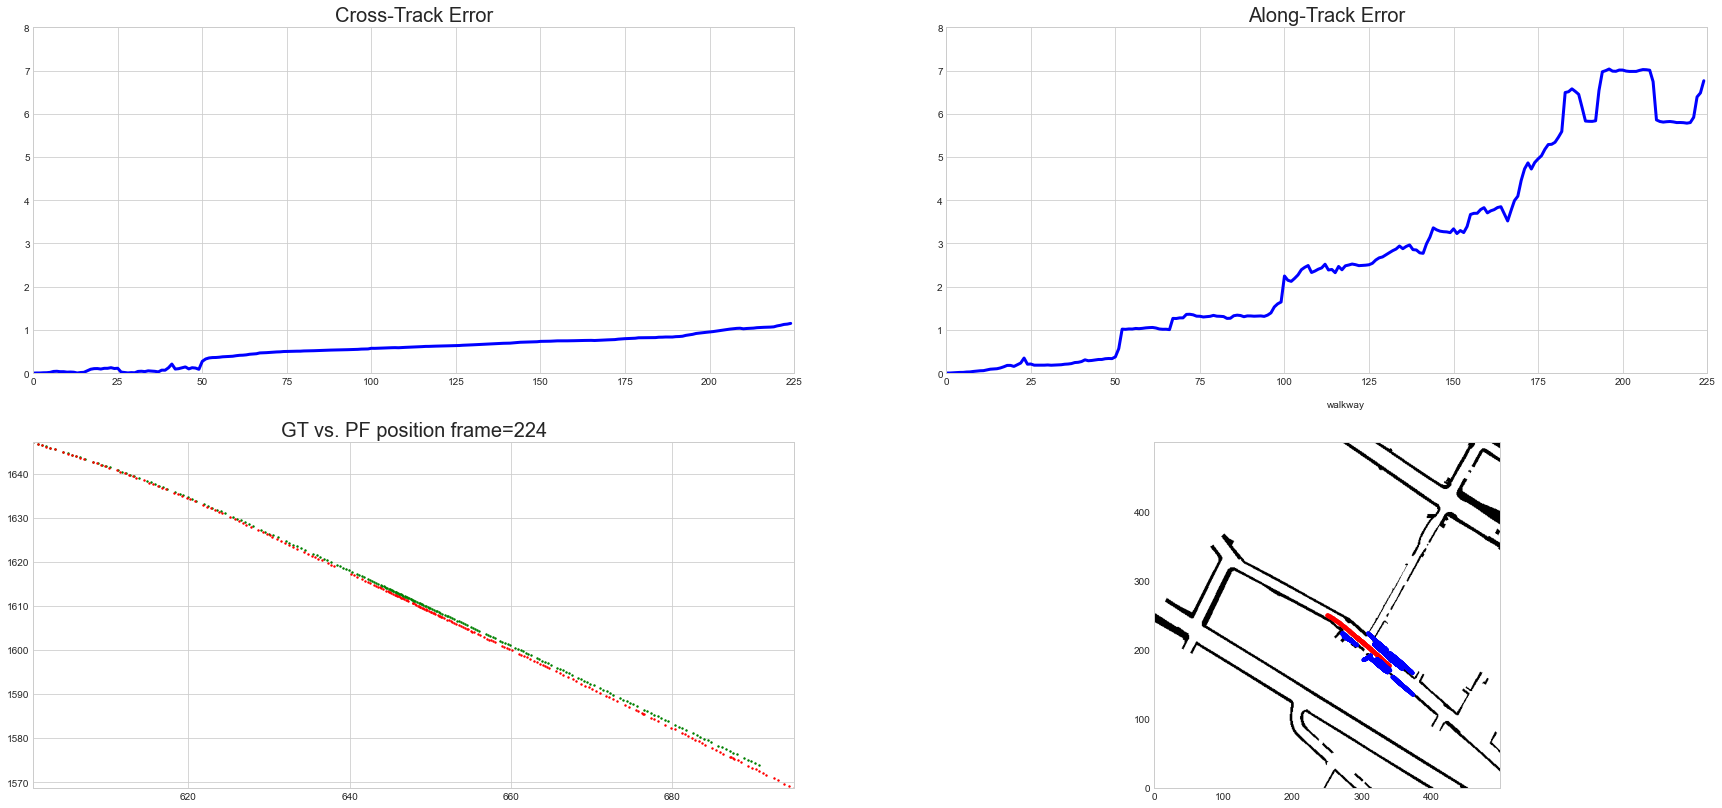

In [5]:
from tracker import Tracker
model = Tracker()
#sim = DynamicSimulation(model)
scene = 0
sim = NuscenesSimulation(model,scene=scene)
sim.run(start=0, N=225, generate_video=True, video_with_priors=True, debug=False)

In [10]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id={} scene_name={} map_name={} 6 scene-0916 singapore-queenstown
{'r1': -1.3291973178027738, 't': 0.0, 'r2': -1.3291973178027736, 'trns': array([ 715.77897665, 1809.68089117,    0.        ])}
{'r1': -1.355894387530094, 't': 0.022231505212692872, 'r2': -1.355464413557046, 'trns': array([ 715.83738214, 1809.41386164,    0.        ])}
{'r1': -1.3822233875697483, 't': 0.0038424334246409363, 'r2': -1.385485979361766, 'trns': array([ 715.89491981, 1809.1069304 ,    0.        ])}
{'r1': -1.4095271275151877, 't': 0.006769384668858184, 'r2': -1.4104003780876107, 'trns': array([ 715.94446175, 1808.80071103,    0.        ])}
{'r1': -1.4370521643069134, 't': 0.04068699310478079, 'r2': -1.4354944783002601, 'trns': array([ 715.98057052, 1808.53546629,    0.        ])}
{'r1': -1.4911470198755297, 't': 0.08352237929645873, 'r2': -1.4918080603984816, 'trns': array([ 716.02735613, 1807.94440109,    0.        ])}
{'r1': -1.5178423249670225, 't': 0.13952710327588275, 'r2': -1.5161355350758263, 'trn

{'r1': -2.359531868615938, 't': 1.0050026015719882, 'r2': -2.364019689254903, 'trns': array([ 705.64077612, 1789.98945551,    0.        ])}
{'r1': -2.3701506474228635, 't': 1.0152634711172106, 'r2': -2.3779510951745295, 'trns': array([ 705.40267757, 1789.76151611,    0.        ])}
{'r1': -2.381601335423931, 't': 1.0545287939620327, 'r2': -2.3886278351607118, 'trns': array([ 705.18927496, 1789.56155005,    0.        ])}
{'r1': -2.394657400653028, 't': 1.0521718347779505, 'r2': -2.4009406722450453, 'trns': array([ 704.93993809, 1789.33363244,    0.        ])}
{'r1': -2.420785357839346, 't': 1.1205356498558006, 'r2': -2.4267502731829733, 'trns': array([ 704.47389684, 1788.92923134,    0.        ])}
{'r1': -2.433462642179755, 't': 1.1534153758252659, 'r2': -2.439077907774804, 'trns': array([ 704.24665135, 1788.73691774,    0.        ])}
{'r1': -2.4471213188616754, 't': 1.1505538934428141, 'r2': -2.452070199949996, 'trns': array([ 703.9895227 , 1788.52498483,    0.        ])}
{'r1': -2.4622

{'r1': 2.3933652033745787, 't': 1.4177728914097456, 'r2': 2.3908898405692063, 'trns': array([ 681.74088831, 1796.77147079,    0.        ])}
{'r1': 2.3933644955718023, 't': 1.4248218366059746, 'r2': 2.390337662033602, 'trns': array([ 681.4574285 , 1797.03552883,    0.        ])}
{'r1': 2.3914070830929335, 't': 1.4266891555370718, 'r2': 2.3889028853424468, 'trns': array([ 681.17431455, 1797.30000449,    0.        ])}
{'r1': 2.390044702105315, 't': 1.432472829118198, 'r2': 2.386910938855638, 'trns': array([ 680.5712587 , 1797.86557615,    0.        ])}
{'r1': 2.3883269967530616, 't': 1.4266662010293436, 'r2': 2.385130069082626, 'trns': array([ 680.23447683, 1798.18257221,    0.        ])}
{'r1': 2.3866047357028726, 't': 1.4364181737721577, 'r2': 2.3822110415062436, 'trns': array([ 679.96118203, 1798.44134446,    0.        ])}
{'r1': 2.3850125064068433, 't': 1.4349469817549367, 'r2': 2.380339367797469, 'trns': array([ 679.64230453, 1798.74435544,    0.        ])}
{'r1': 2.3832882495678493,

{'r1': 2.6007304416586443, 't': 1.7934280156123883, 'r2': 2.5992800163672567, 'trns': array([ 660.74527554, 1816.44070312,    0.        ])}
{'r1': 2.6192471912411364, 't': 1.7862612167967769, 'r2': 2.618301225541001, 'trns': array([ 660.4926833 , 1816.58554733,    0.        ])}
{'r1': 2.639440257630092, 't': 1.7958110954684572, 'r2': 2.634680568348806, 'trns': array([ 660.23608429, 1816.72717556,    0.        ])}
{'r1': 2.659934045378356, 't': 1.7630125533668604, 'r2': 2.657455100457145, 'trns': array([ 659.94262236, 1816.88054987,    0.        ])}
{'r1': 2.6815937664853777, 't': 1.7611118977145357, 'r2': 2.681470332743433, 'trns': array([ 659.68432475, 1817.00772669,    0.        ])}
{'r1': 2.727311522963439, 't': 1.7513542748574324, 'r2': 2.7252055001993387, 'trns': array([ 659.14611404, 1817.24411824,    0.        ])}
{'r1': 2.7511376795208955, 't': 1.7510076486738564, 'r2': 2.751540415798998, 'trns': array([ 658.86168697, 1817.36022088,    0.        ])}
{'r1': 2.7767622773045475, '

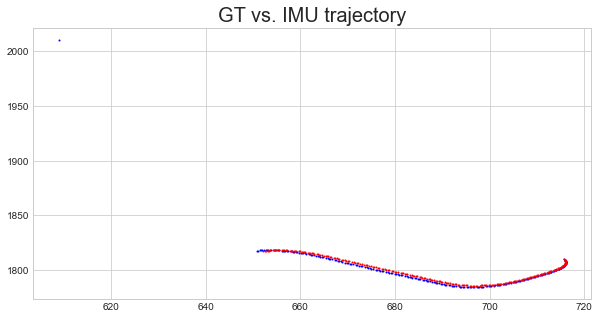

In [4]:

directory = r"C:\Users\gadli\old_pc\Tau\Thesis\nuScenes\v1.0-mini"
scene = 6
dataset = NuscenesDataset(directory=directory,scene=scene)
N = 225
gt = np.zeros((N, 2))
imu = np.zeros((N, 2))
for t in range(0,225):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu[t, :] = trns1[0:2]
    odom = dataset.getOdometry()
    print(odom)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title("GT vs. IMU trajectory", fontsize=20)
ax.scatter(gt[:, 0],gt[:, 1],color='blue',s=1)
ax.scatter(imu[:, 0],imu[:, 1],color='red',s=1)

In [28]:
a = np.zeros((46,46,1))
a.shape[1:]

(46, 1)

In [4]:
from pyquaternion import Quaternion

Quaternion.Inverse()

AttributeError: type object 'Quaternion' has no attribute 'Inverse'